In [59]:
from pymongo import MongoClient
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
import operator
import json
from collections import Counter
from nltk.corpus import stopwords
from nltk import bigrams 

## Load Data from Mongo

In [60]:
client = MongoClient('localhost', 27017)
db = client.NEBFTwitter_db
collection = db.twitter_collection

In [61]:
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 

In [62]:
punctuation = list(string.punctuation)
stop_words = ENGLISH_STOP_WORDS
stop = stopwords.words('english') + punctuation + ['rt', 'via','amp'] + list(stop_words)
count_bigram=Counter()
for twitter in collection.find():
    try: 
        tweet = twitter["text"]
        tweet = tweet.lower()
        terms_stop = [term for term in preprocess(tweet) if term not in stop]
        terms_bigram = bigrams(terms_stop)
        # Update the counter
        count_bigram.update(terms_bigram)
    except Exception:
        pass
# Print the first 5 most frequent words
print(count_bigram.most_common(50))

[(('#hiring', '#careerarc'), 4333), (('😂', '😂'), 3614), (("we're", '#hiring'), 2780), (('❤', '️'), 2037), (('great', 'fit'), 1957), (('recommend', '#job'), 1940), (('click', 'apply'), 1873), (('want', 'work'), 1860), (('latest', '#job'), 1836), (('#job', 'opening'), 1820), (('😭', '😭'), 1583), (('happy', 'birthday'), 1494), (("you're", 'looking'), 1035), (('looking', 'work'), 1014), (('check', '#job'), 1012), (('#job', 'great'), 1007), (('interested', '#job'), 968), (('#hiring', 'click'), 953), (('latest', 'opening'), 934), (('view', 'latest'), 934), (('#job', 'click'), 931), (('read', 'latest'), 930), (('#hiring', 'read'), 924), (('click', 'details'), 912), (('team', 'latest'), 896), (('#jobs', '#hiring'), 881), (('💗', '💗'), 863), (("can't", 'wait'), 738), (('#jobs', '#careerarc'), 685), (('#blackfriday', 'deals'), 666), (('new', 'york'), 658), (('black', 'friday'), 598), (('😍', '😍'), 574), (('#veterans', '#hiring'), 534), (('️', '❤'), 498), (('°', 'f'), 455), (("don't", 'know'), 444),

In [63]:
count_hash=Counter()
for twitter in collection.find():
    try:
        tweet = twitter["text"]
        tweet = tweet.lower()
        terms_hash = [term for term in preprocess(tweet)
                  if term.startswith('#')]
        # Update the counter
        count_hash.update(terms_hash)
    except Exception:
        pass
# Print the first 5 most frequent words
print(count_hash.most_common(20))

[('#job', 10206), ('#hiring', 9070), ('#careerarc', 5227), ('#blackfriday', 4051), ('#jobs', 2225), ('#hospitality', 1323), ('#retail', 1062), ('#veterans', 959), ('#sales', 705), ('#nursing', 648), ('#healthcare', 645), ('#tbt', 536), ('#newyork', 440), ('#transportation', 431), ('#', 402), ('#chicago', 388), ('#customerservice', 313), ('#xboxlive', 299), ('#it', 295), ('#boston', 284)]


In [64]:
count_at=Counter()

for twitter in collection.find():
    try:
        tweet = twitter["text"]
        tweet = tweet.lower()
        terms_at = [term for term in preprocess(tweet)
                  if term.startswith('@')]
        # Update the counter
        count_at.update(terms_at)
    except Exception:
        pass
# Print the first 5 most frequent words
print(count_at.most_common(20))

[('@', 4166), ('@realdonaldtrump', 546), ('@xbox', 296), ('@vycadetheoracle', 191), ('@foxnews', 182), ('@potus', 167), ('@cnn', 166), ('@bfads', 158), ('@harry_styles', 134), ('@nytimes', 105), ('@youtube', 99), ('@crowdtappers', 97), ('@hillaryclinton', 91), ('@ptpa', 89), ('@simplystacienet', 83), ('@berniesanders', 81), ('@kurteichenwald', 77), ('@qvc', 74), ('@joyannreid', 73), ('@jccaylen', 70)]


In [65]:
from collections import defaultdict
# remember to include the other import from the previous post
 
com = defaultdict(lambda : defaultdict(int))
 
# f is the file pointer to the JSON data set
for twitter in collection.find():
    try:
        tweet = twitter["text"]
        tweet = tweet.lower()
        terms_only = [term for term in preprocess(tweet)
                      if term not in stop
                      and not term.startswith(('#', '@'))]
    except Exception:
        pass
 
    # Build co-occurrence matrix
    for i in range(len(terms_only)-1):           
        for j in range(i+1, len(terms_only)):
            w1, w2 = sorted([terms_only[i], terms_only[j]])               
            if w1 != w2:
                com[w1][w2] += 1

In [66]:
com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Get the most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:20])

[(('❤', '️'), 4319), (('💗', '😭'), 3302), (('🏻', '🖕'), 2991), (('latest', 'opening'), 2757), (('fit', 'great'), 1959), (('want', 'work'), 1891), (('apply', 'click'), 1875), (('click', "we're"), 1856), (('😂', '😭'), 1852), (('birthday', 'happy'), 1614), (('‼', '️'), 1310), (('🏽', '👏'), 1083), (('hair', '💕'), 1069), (('work', "you're"), 1044), (('looking', "you're"), 1044), (('looking', 'work'), 1035), (('check', "you're"), 1025), (('check', 'looking'), 1023), (('check', 'work'), 1017), (('latest', 'team'), 1002)]


In [68]:
search_word = "retail" # pass a term as a command-line argument
count_search = Counter()
for twitter in collection.find():
    try:
        tweet = twitter["text"]
        tweet = tweet.lower()
        terms_only = [term for term in preprocess(tweet)
                      if term not in stop
                      and not term.startswith(('#', '@'))]
        if search_word in terms_only:
            count_search.update(terms_only)
    except Exception:
        pass
print("Co-occurrence for %s:" % search_word)
print(count_search.most_common(20))



Co-occurrence for retail:
[('retail', 266), ('sales', 137), ("we're", 94), ('latest', 87), ('click', 86), ('apply', 83), ('service', 69), ('opening', 52), ('read', 44), ('great', 43), ('fit', 42), ('seasonal', 42), ('time', 40), ('customer', 39), ('…', 38), ("macy's", 35), ('recommend', 33), ('specialist', 33), ('holiday', 32), ('team', 32)]


In [55]:
twitters = []
for twitter in collection.find():
    twitters.append(twitter['text'])

In [37]:
twitters = [x.lower() for x in twitters]

In [10]:
def remove_urls(text):
    text = re.sub(r"(?:\@|http?\://)\S+", "", text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text

In [11]:
twitters = [remove_urls(x) for x in twitters ]

In [13]:
word_data = pd.Series(twitters).to_frame(name="twitter")
word_data['loc'] = "Manhattan"

In [15]:
stop_words = ENGLISH_STOP_WORDS

In [15]:
rem = string.digits + '/\-+.'
rem_chars = lambda a: ''.join([i for i in a if i not in rem])
word_data['twitter'] = word_data['twitter'].apply(rem_chars)


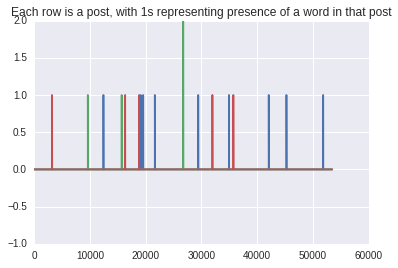

In [16]:
vec = CountVectorizer(max_df=.6, stop_words=stop_words)
vec_tar = LabelEncoder()

counts = vec.fit_transform(word_data['twitter'])
targets = vec_tar.fit_transform(word_data['loc'])
plt.plot(counts[:3].toarray().T)
plt.ylim([-1, 2])
plt.title('Each row is a post, with 1s representing presence of a word in that post')

In [19]:
top_words = {}
for itrg in np.unique(targets):
    loc = vec_tar.classes_[itrg]
    # Pull only the data points assigned to the current loction
    icounts = counts[targets == itrg, :].sum(0).squeeze()
    
    # Which counts had at least five occurrences
    msk_top_words = icounts > 400
    
    # The inverse transform turns the vectors back into actual words
    top_words[loc] = vec.inverse_transform(msk_top_words)[0]

In [20]:
top_words

{'Manhattan': array(['amazing', 'amp', 'apply', 'ass', 'avenue', 'bad', 'beautiful',
        'best', 'better', 'big', 'birthday', 'black', 'brooklyn',
        'careerarc', 'check', 'city', 'class', 'cleared', 'click',
        'clinton', 'come', 'coming', 'construction', 'day', 'days', 'did',
        'didn', 'does', 'doesn', 'doing', 'don', 'election', 'exit', 'feel',
        'fit', 'friends', 'fuck', 'fucking', 'game', 'getting', 'girl',
        'god', 'going', 'gonna', 'good', 'got', 'great', 'gt', 'guy',
        'guys', 'halloween', 'happy', 'hate', 'having', 'help', 'hillary',
        'hiring', 'home', 'hope', 'im', 'incident', 'job', 'jobs', 'join',
        'just', 'know', 'latest', 'let', 'life', 'like', 'line', 'little',
        'live', 'll', 'lmao', 'lol', 'long', 'look', 'looking', 'lot',
        'love', 'make', 'makes', 'man', 'manhattan', 'miss', 'morning',
        'music', 'need', 'new', 'newyork', 'night', 'nj', 'november', 'ny',
        'nyc', 'oh', 'opening', 'park', 'par

In [21]:
unique_words = {}
for loc, words in top_words.items():
    others = top_words.copy()
    others.pop(loc)
    unique_words[loc] = [wrd for wrd in top_words[loc]
                         if wrd not in np.hstack(others.values())]
for loc, words in unique_words.items():
    print('{0}: {1}\n\n---\n'.format(loc, words))

IndexError: list index out of range